In [2]:
import os
import shutil
import hashlib

# Define your project directory and labels
PROJECT_DIR = "/kaggle/input/brain-tumor-mri-dataset"
OUTPUT_DIR = "/kaggle/working/filtered-dataset"
LABELS = ["glioma", "meningioma", "notumor", "pituitary"]  # Corrected the typo from "pituatary" to "pituitary"

def compute_hash(file):
    """Compute the MD5 hash of a file."""
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def list_files(hash_dict):
    """List files and compute their hashes."""
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]

def copy_unique_files(hash_dict):
    """Copy unique files to a new directory."""
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            new_dir = os.path.join(OUTPUT_DIR, data_type, label)
            os.makedirs(new_dir, exist_ok=True)

    for hash_value, file_paths in hash_dict.items():
        # Copy only the first file (unique file) to the new directory
        unique_file_path = file_paths[0]
        relative_path = os.path.relpath(unique_file_path, PROJECT_DIR)
        new_file_path = os.path.join(OUTPUT_DIR, relative_path)
        shutil.copy2(unique_file_path, new_file_path)
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Identified duplicate (hash: {hash_value}): {file_path}")

# Main execution
hash_dict = {}
list_files(hash_dict)
copy_unique_files(hash_dict)

Identified duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0176.jpg
Identified duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0211.jpg
Identified duplicate (hash: 3cb1d6594ea1a7391608e9bc8245529c): /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0143.jpg
Identified duplicate (hash: 333ca271271562e025951545e76a8b0b): /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0249.jpg
Identified duplicate (hash: ab525628d00898aa6b1088d9c1d5a785): /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0175.jpg
Identified duplicate (hash: a501e6ea3748d3aebea8e8735268ec5b): /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0238.jpg
Identified duplicate (hash: b0481c04cf82055b53bed325556f744e): /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0135.jpg
Identified duplicate (hash: 832c3e0243e8fafe4313d8

In [3]:
import os

data_dir = '/kaggle/working/filtered-dataset'
print(os.listdir(data_dir))


['Testing', 'Training']


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder


In [5]:

train_path = '/kaggle/working/filtered-dataset/Training'
test_path = '/kaggle/working/filtered-dataset/Testing'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = ImageFolder(train_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 output classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with checkpointing
num_epochs = 10
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Validation after each epoch
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Accuracy after epoch {epoch+1}: {accuracy:.2f}%')
        
        # Save checkpoint if this is the best model so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'accuracy': accuracy,
            }, 'best_model.pth')
            
            print('Saved best model')

print('Finished Training')

Epoch [1/10], Step [100/173], Loss: 0.8846
Accuracy after epoch 1: 78.92%
Saved best model
Epoch [2/10], Step [100/173], Loss: 0.3687
Accuracy after epoch 2: 87.05%
Saved best model
Epoch [3/10], Step [100/173], Loss: 0.2132
Accuracy after epoch 3: 90.62%
Saved best model
Epoch [4/10], Step [100/173], Loss: 0.1128
Accuracy after epoch 4: 94.11%
Saved best model
Epoch [5/10], Step [100/173], Loss: 0.0762
Accuracy after epoch 5: 94.69%
Saved best model
Epoch [6/10], Step [100/173], Loss: 0.0284
Accuracy after epoch 6: 94.94%
Saved best model
Epoch [7/10], Step [100/173], Loss: 0.0246
Accuracy after epoch 7: 94.52%
Epoch [8/10], Step [100/173], Loss: 0.0299
Accuracy after epoch 8: 94.77%
Epoch [9/10], Step [100/173], Loss: 0.0390
Accuracy after epoch 9: 95.93%
Saved best model
Epoch [10/10], Step [100/173], Loss: 0.0109
Accuracy after epoch 10: 96.68%
Saved best model
Finished Training


In [8]:
# Load best model checkpoint (optional)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()


correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {(100 * correct / total):.2f}%')



Accuracy on the test set: 96.68%


NameError: name 'plt' is not defined

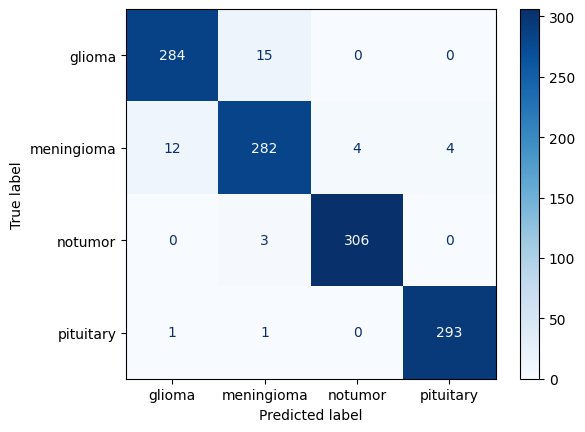

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model.eval()
all_predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

cm = confusion_matrix(true_labels, all_predictions)

# Display confusion matrix
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Assuming this order corresponds to your label indices
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [10]:

model.eval()


train_correct = 0
train_total = 0

with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_accuracy = 100 * train_correct / train_total
print(f'Accuracy on the training set: {train_accuracy:.2f}%')


Accuracy on the training set: 99.98%


In [11]:

torch.save(model.state_dict(), 'model.pth')
print('save')

save


In [14]:
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path)
    image = transform(image)  # Apply the same transformations as in training
    image = image.unsqueeze(0)  # Add batch dimension
    return image


In [15]:
# Load the model checkpoint
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [16]:
# Load the model checkpoint
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

The predicted class for the image is: glioma


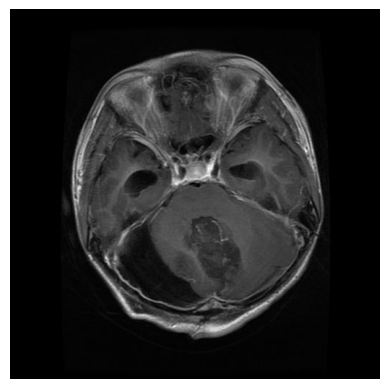

In [17]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the transformation used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load your model
model = CNN()
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path)
    image = transform(image)  # Apply the same transformations as in training
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def predict(image_path):
    """Predict the class of the image."""
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

def get_class_label(index):
    """Map the index to the class label."""
    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    return labels[index]

def display_image(image_path):
    """Display the image."""
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg'  # Replace with your image path

predicted_index = predict(image_path)
predicted_label = get_class_label(predicted_index)

print(f'The predicted class for the image is: {predicted_label}')

# Display the image
display_image(image_path)




The predicted class for the image is: notumor


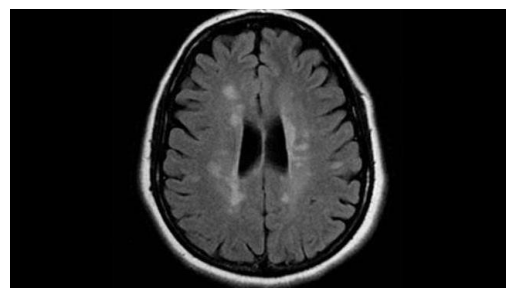

In [20]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the transformation used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load your model
model = CNN()
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path)
    image = transform(image)  # Apply the same transformations as in training
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def predict(image_path):
    """Predict the class of the image."""
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

def get_class_label(index):
    """Map the index to the class label."""
    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    return labels[index]

def display_image(image_path):
    """Display the image."""
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = '/kaggle/working/filtered-dataset/Testing/notumor/Te-no_0220.jpg'  # Replace with your image path

predicted_index = predict(image_path)
predicted_label = get_class_label(predicted_index)

print(f'The predicted class for the image is: {predicted_label}')

# Display the image
display_image(image_path)




In [ ]:
#train 98.99
#test 96.99